# Spectral maps

spotter can be used to model time series spectra of non-uniform stars. In this tutorial we showcase some of these features.

```{important}
The features shown in this tutotrial are still experimental and not tested against ground truth. Use with care!
```

## A simple spotted surface

We first create a surface with a single spot

In [149]:
from spotter import Star
from spotter import core, show

star = Star.from_sides(2**4, period=0.05, u=(0.2, 0.2), inc=1.4)
spot = 0.8 * core.spot(star.sides, 0.0, 0.0, 0.4)
star = star - spot

and assume that the star and its spot share same spectrum

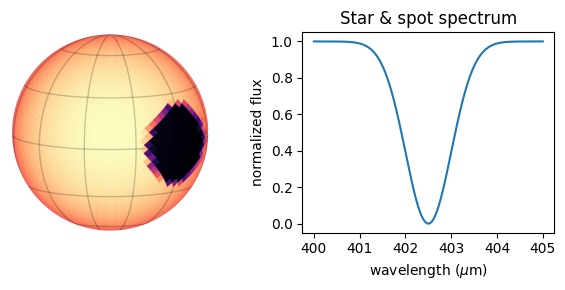

In [150]:
import matplotlib.pyplot as plt
import jax.numpy as jnp


def gaussian(x, mu, sigma):
    return jnp.exp(-((x - mu) ** 2) / (2 * sigma**2))


wv = jnp.linspace(400, 405, 500) * 1e-9
star_spectrum = 1 - gaussian(wv, wv.mean(), 0.5e-9)

plt.figure(figsize=(6, 3))
ax = plt.subplot(121)
show(star, star.period / 8, ax=ax)
ax = plt.subplot(122)
plt.plot(wv * 1e9, star_spectrum)
plt.xlabel("wavelength ($\mu$m)")
plt.title("Star & spot spectrum")
_ = plt.ylabel("normalized flux")
plt.tight_layout()

From there we can compute the observed intensity of the star at a given phase 

In [151]:
from spotter.doppler import spectrum

observed_spectrum = spectrum(star, wv, star_spectrum, 0.1)

Let's plot the observed spectrum at different phases

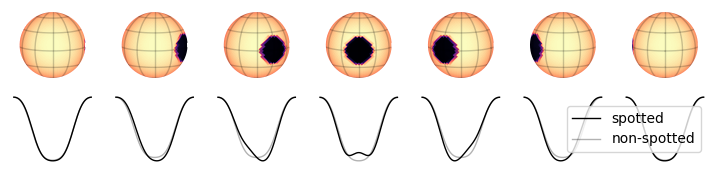

In [152]:
n = 7
fig, axes = plt.subplots(2, n, figsize=(9, 2 * n / n))
nonspotted_spectrum = spectrum(star, wv, star_spectrum, jnp.pi)

for i, phase in enumerate(jnp.linspace(jnp.pi / 2, -jnp.pi / 2, n)):
    ax = axes[1, i]
    ax.plot(spectrum(star, wv, star_spectrum, phase), c="k", lw=1, label="spotted")
    ax.plot(nonspotted_spectrum, "-", alpha=0.3, c="k", lw=1, label="non-spotted")
    ax.axis("off")

    ax = axes[0, i]
    show(star, star.period * phase / (2 * jnp.pi), ax=ax)

    if i == n - 1:
        plt.legend()

## Spectral spatial maps

Because of their cooler temperatures (among other factors), starspots should have their own spectrum, different from the star's. Let's show how to model this.

Le'ts make the spot in this example more interesting by using a Gaussian radial profile

/Users/lgarcia/code/spotter/spotter/star.py:48: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return cls(y, **kwargs)
/Users/lgarcia/code/spotter/spotter/star.py:82: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return self.__class__(y, self.u, self.inc, self.period)


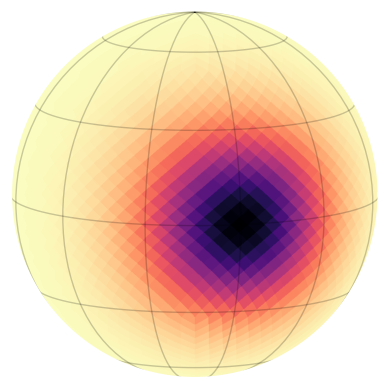

In [153]:
star = Star.from_sides(2**4, period=0.05, inc=1.4)
spot = 2 * core.soft_spot(star.sides, 0.0, 0.0, 0.2)
star = star - spot

show(star, 0.002)

We now define the spectra of the star and the spot separately

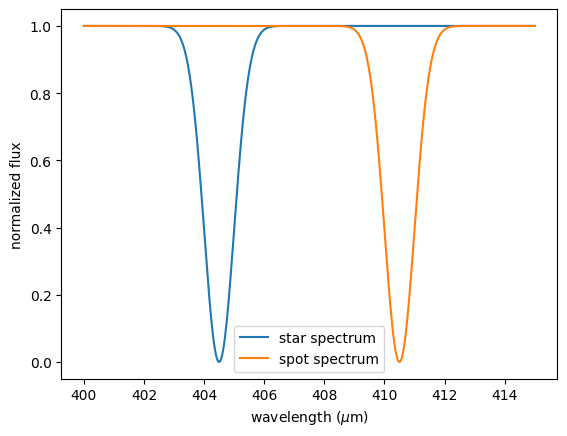

In [155]:
wv = jnp.linspace(400, 415, 500) * 1e-9
star_spectrum = 1 - gaussian(wv, wv.mean() - 0.2 * jnp.ptp(wv), 0.5e-9)
spotted_spectrum = 1 - gaussian(wv, wv.mean() + 0.2 * jnp.ptp(wv), 0.5e-9)

plt.plot(wv * 1e9, star_spectrum, label="star spectrum")
plt.plot(wv * 1e9, spotted_spectrum, label="spot spectrum")
plt.legend()
plt.xlabel("wavelength ($\mu$m)")
_ = plt.ylabel("normalized flux")

The next step consists in setting the spectra of each pixel in the map

In [156]:
import numpy as np

spectra = np.zeros((star.size, len(wv)))
spectra[:] = star.y[:, None] * star_spectrum[None, :]
spectra += spot[:, None] * spotted_spectrum[None, :]

This result in a spectral spatial map of shape *(pixels, wavelength)*

In [158]:
spectra.shape

(3072, 500)

As in the previous example, here is the observed spectrum at different phases

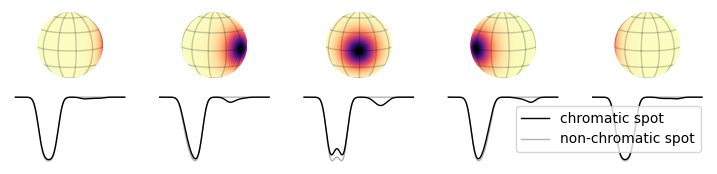

In [159]:
n = 5
fig, axes = plt.subplots(2, n, figsize=(9, 2 * n / n))
nonspotted_spectrum = spectrum(star, wv, star_spectrum, jnp.pi)

for i, phase in enumerate(jnp.linspace(jnp.pi / 1.8, -jnp.pi / 1.8, n)):
    ax = axes[1, i]
    ax.plot(spectrum(star, wv, spectra, phase), c="k", lw=1, label="chromatic spot")
    ax.plot(
        spectrum(star, wv, star_spectrum, phase),
        c="k",
        lw=1,
        alpha=0.3,
        label="non-chromatic spot",
    )
    ax.axis("off")

    ax = axes[0, i]
    show(star, star.period * phase / (2 * jnp.pi), ax=ax)

    if i == n - 1:
        plt.legend()